


# Project: Kaggle Soccer Database of europe match from 2008 to 2016

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>




<a id='intro'></a>
## Introduction
the data analysis process show the best team in europe and the the attributes of the bast team

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams.update({'font.size': 20})

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [2]:
df_match = pd.read_csv('match.csv')
df_team=pd.read_csv('Team.csv')
df_teamatr=pd.read_csv('Team_Attributes.csv')



### Data Cleaning (convert date from object to datetime)

In [3]:
df_match['date']=pd.to_datetime(df_match['date'])
df_teamatr['date']=pd.to_datetime(df_teamatr['date'])

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 what is the most winning team in Europe form 2008 to 2016?

### crate new column name winner show the winner of evry game and change the team api id to the name of the team

In [4]:
df_match['winner']= np.where(
    df_match['home_team_goal'] == df_match['away_team_goal'], 0, np.where(
    df_match['home_team_goal'] >  df_match['away_team_goal'], df_match['home_team_api_id'], df_match['away_team_api_id'])) 
print (df_match.info())
print('-'*40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 6 columns):
date                25979 non-null datetime64[ns]
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
winner              25979 non-null int64
dtypes: datetime64[ns](1), int64(5)
memory usage: 1.2 MB
None
----------------------------------------


### extract the top 10 winner teams from all Europen teams

In [5]:
m = df_team.set_index(['team_api_id'])['team_long_name'].to_dict()
v = df_match.filter(like='winner')
df_match[v.columns] = v.replace(m)
x=df_match['winner'].value_counts().reset_index()[1:11]
print (x)

                index  winner
1        FC Barcelona     234
2      Real Madrid CF     228
3              Celtic     218
4    FC Bayern Munich     193
5   Manchester United     192
6            Juventus     189
7          SL Benfica     185
8            FC Porto     183
9                Ajax     181
10           FC Basel     180


### Create a visualization showing the most winnig team in Europe

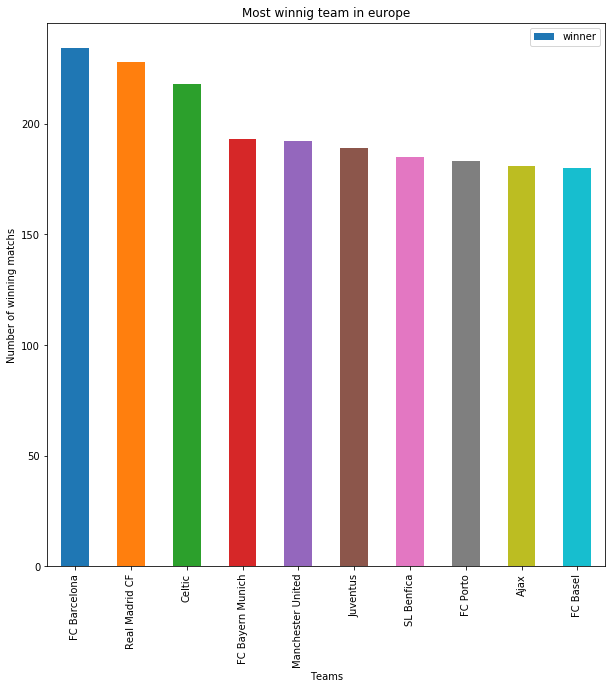

In [6]:
x.plot(x='index',y='winner',kind='bar',figsize=(10,10))
plt.title('Most winnig team in europe')
plt.xlabel('Teams')
plt.ylabel('Number of winning matchs');

### Research Question 2  what is FC Barcelona development during the period from 2008 to 2016

In [7]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investiga


### create new dataframe with the information of FC Barcelona winng during all seasons


In [8]:
df_barg=df_match.loc[df_match['winner']=='FC Barcelona']
df_barg['date']=df_barg['date'].dt.year
df_bar=df_barg.groupby('date')[['winner']].count()
df_barg.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,winner
21534,2008,8634,10281,6,0,FC Barcelona
21546,2008,8479,8634,0,2,FC Barcelona
21563,2008,8302,8634,0,3,FC Barcelona
21571,2008,8634,10267,4,0,FC Barcelona
21577,2008,8634,8633,2,0,FC Barcelona


### Create a visualization showing the number of matches that FC Barcelona win evry season

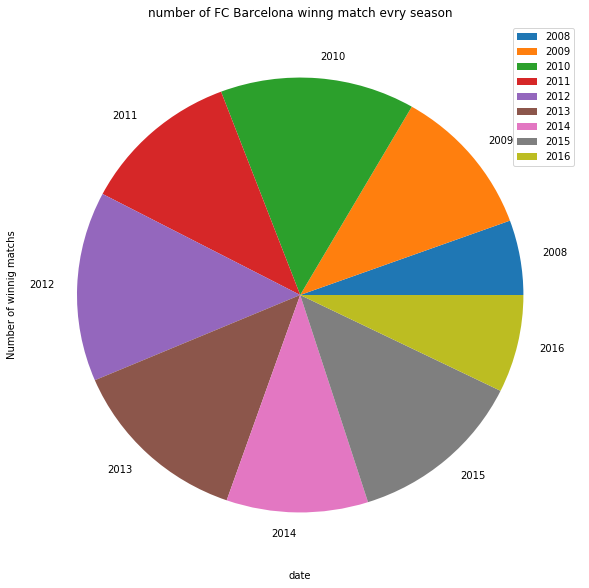

In [9]:
df_bar.plot(y = 'winner',kind='pie',figsize=(10,10))
plt.title('number of FC Barcelona winng match evry season')
plt.xlabel('date')
plt.ylabel('Number of winnig matchs');

### Research Question 3  what is FC Barcelona attack attributes during 2010 (high winning period) and 2014 (low winnig period)


### create new dataframe with the is FC Barcelona attack attributes during every season

In [10]:
df_teamatr=df_teamatr.loc[:,['team_api_id','date','buildUpPlaySpeed','buildUpPlayPassing','chanceCreationPassing','chanceCreationCrossing','chanceCreationShooting']]
df_teamatr['date']=pd.to_datetime(df_teamatr['date']).dt.date
df_teamatr['date']=pd.to_datetime(df_teamatr['date'])
df_teamatr.info()
df_teamatr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 7 columns):
team_api_id               1458 non-null int64
date                      1458 non-null datetime64[ns]
buildUpPlaySpeed          1458 non-null int64
buildUpPlayPassing        1458 non-null int64
chanceCreationPassing     1458 non-null int64
chanceCreationCrossing    1458 non-null int64
chanceCreationShooting    1458 non-null int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 79.8 KB


,team_api_id,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting
0,9930,2010-02-22,60,50,60,65,55
1,9930,2014-09-19,52,56,54,63,64
2,9930,2015-09-10,47,54,54,63,64
3,8485,2010-02-22,70,70,70,70,70
4,8485,2011-02-22,47,52,53,48,52


In [11]:
df_teamatr['date']=df_teamatr['date'].dt.year
df_teamatr.head()

,team_api_id,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting
0,9930,2010,60,50,60,65,55
1,9930,2014,52,56,54,63,64
2,9930,2015,47,54,54,63,64
3,8485,2010,70,70,70,70,70
4,8485,2011,47,52,53,48,52


In [12]:
m = df_team.set_index(['team_api_id'])['team_long_name'].to_dict()
v = df_teamatr.filter(like='team_api_id')
df_teamatr[v.columns] = v.replace(m)

In [13]:
df_teamatr=df_teamatr.loc[df_teamatr['team_api_id']=='FC Barcelona']
df_teamatr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 118 to 123
Data columns (total 7 columns):
team_api_id               6 non-null object
date                      6 non-null int64
buildUpPlaySpeed          6 non-null int64
buildUpPlayPassing        6 non-null int64
chanceCreationPassing     6 non-null int64
chanceCreationCrossing    6 non-null int64
chanceCreationShooting    6 non-null int64
dtypes: int64(6), object(1)
memory usage: 384.0+ bytes


In [14]:
df_teamatr.set_index('date',inplace=True)

### Create a visualization showing the difference between fc barcelona attack attributes in 2010 and 2014 

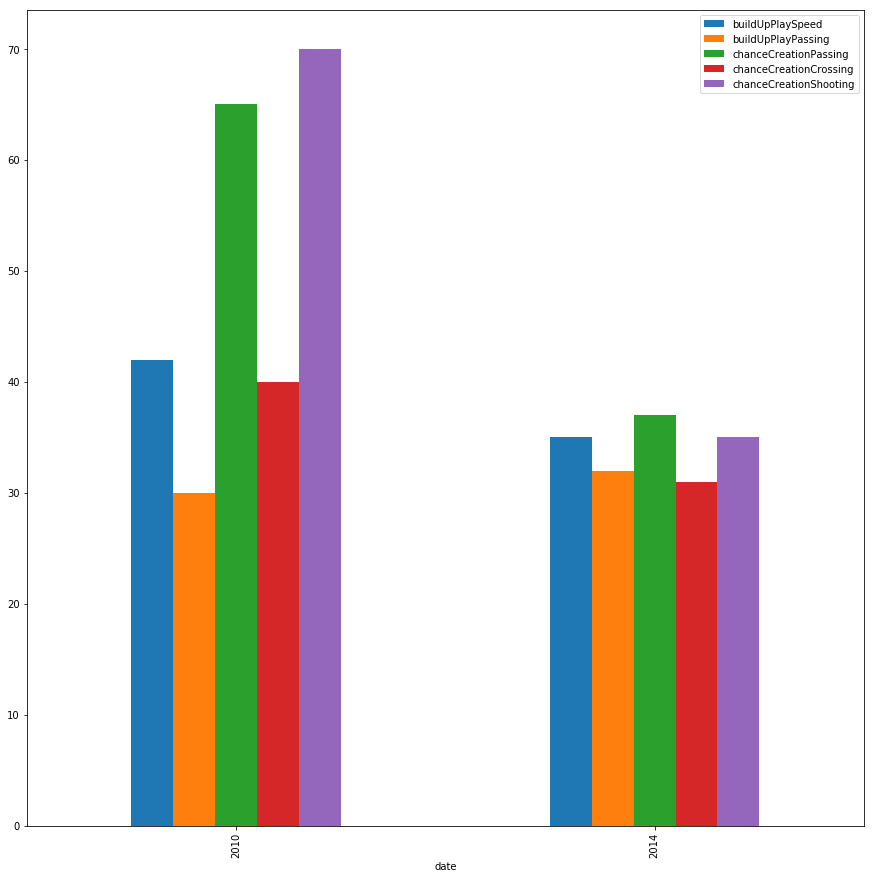

In [15]:
df_teamatr.iloc[[0,4],:].plot(y=[('buildUpPlaySpeed'),('buildUpPlayPassing'),('chanceCreationPassing'),('chanceCreationCrossing'),('chanceCreationShooting')],kind='bar',figsize=(15,15));

### how many goals did FC Barcelona score evry season?

### extract the goals scored by FC Barcelona during all home matchs

In [16]:
home_goal=df_match[df_match['home_team_api_id']==8634]
home_goal['date']=home_goal['date'].dt.year
home_goal.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,winner
21534,2008,8634,10281,6,0,FC Barcelona
21549,2008,8634,8305,1,1,0
21571,2008,8634,10267,4,0,FC Barcelona
21577,2008,8634,8633,2,0,FC Barcelona
21602,2009,8634,8661,3,1,FC Barcelona


### extract the goals scored by FC Barcelona during all away  matchs

In [17]:
away_goal=df_match[df_match['away_team_api_id']==8634]
away_goal['date']=away_goal['date'].dt.year
away_goal.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,winner
21520,2008,8388,8634,1,0,CD Numancia
21546,2008,8479,8634,0,2,FC Barcelona
21563,2008,8302,8634,0,3,FC Barcelona
21592,2008,10205,8634,1,2,FC Barcelona
21613,2009,8371,8634,2,3,FC Barcelona


### merge the tow dataframe togather 

In [18]:
df_merge=home_goal.merge(away_goal,on='date')
df_merge=df_merge.drop(['home_team_api_id_x','away_team_api_id_x','away_team_goal_x','winner_x','home_team_api_id_y','away_team_api_id_y','home_team_goal_y','winner_y'],axis=1)

### sum the goals scored by FC Barcelona every season

In [19]:
df_merge=df_merge.groupby('date').sum()
df_merge['total']=df_merge['home_team_goal_x']+df_merge['away_team_goal_y']
df_merge

,home_team_goal_x,away_team_goal_y,total
date,,,
2008,224,160,384
2009,1026,702,1728
2010,1102,1100,2202
2011,1134,620,1754
2012,1239,1116,2355
2013,1235,798,2033
2014,1188,494,1682
2015,1134,920,2054
2016,468,330,798


### Create a visualization showing the difference between fc barcelona home goals and away goals

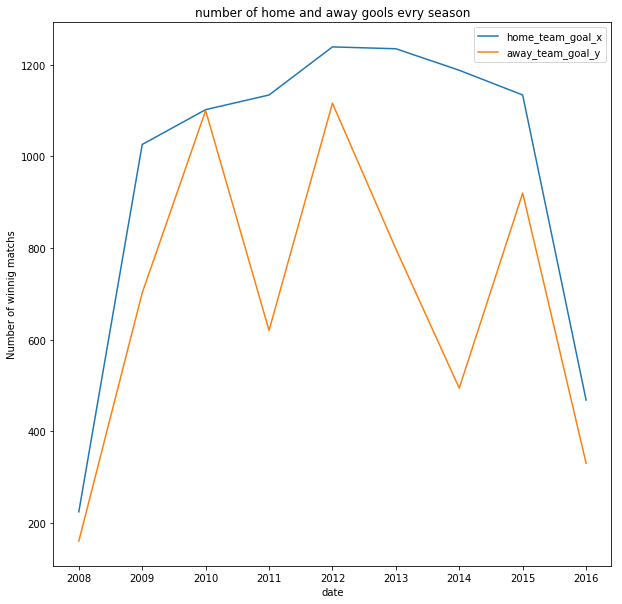

In [20]:
df_merge.plot(y=['home_team_goal_x','away_team_goal_y'],figsize=(10,10))
plt.title('number of home and away gools evry season')
plt.xlabel('date')
plt.ylabel('Number of winnig matchs');

## Limitations
### 1. some files has alot of not necessary data like match file
### 2. some data is for different dates like the match file and 

<a id='conclusions'></a>
## Conclusions


### 1. as showing in the plot  FC Barcelona is the most winning team in Europe
### 2. as showing in the plot  FC Barcelona most winning year was 2010 and 2012
### 3. as showing in the plot when compering the attack during 2010 high winning year and 2014 less winnig year the most affected reason is chance Creation Shooting and chance Creation Passing
### 4. the home and away goals was very colse during FC Barcelona most winning year was 2010 and 2012



In [21]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0